In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from prophet import Prophet
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression
import random
import statsmodels.api as sm
import scipy
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from statsmodels.tsa.forecasting.theta import ThetaModel


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
train = pd.read_csv('train.csv', parse_dates=['first_day_of_month'])
test=pd.read_csv('test.csv', parse_dates=['first_day_of_month'])
census=pd.read_csv('census_starter.csv')

In [ ]:
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [ ]:
train.dtypes

row_id                           object
cfips                             int64
county                           object
state                            object
first_day_of_month       datetime64[ns]
microbusiness_density           float64
active                            int64
dtype: object

In [ ]:
test.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


In [ ]:
test=test.sort_values(['cfips','first_day_of_month']).reset_index(drop=True)
test.head()


,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1001_2022-12-01,1001,2022-12-01
2,1001_2023-01-01,1001,2023-01-01
3,1001_2023-02-01,1001,2023-02-01
4,1001_2023-03-01,1001,2023-03-01


# Visualization and exploratory data analysis

In [ ]:
# Visualize data
unique_cfips= train.cfips.unique()
len(unique_cfips)

3135

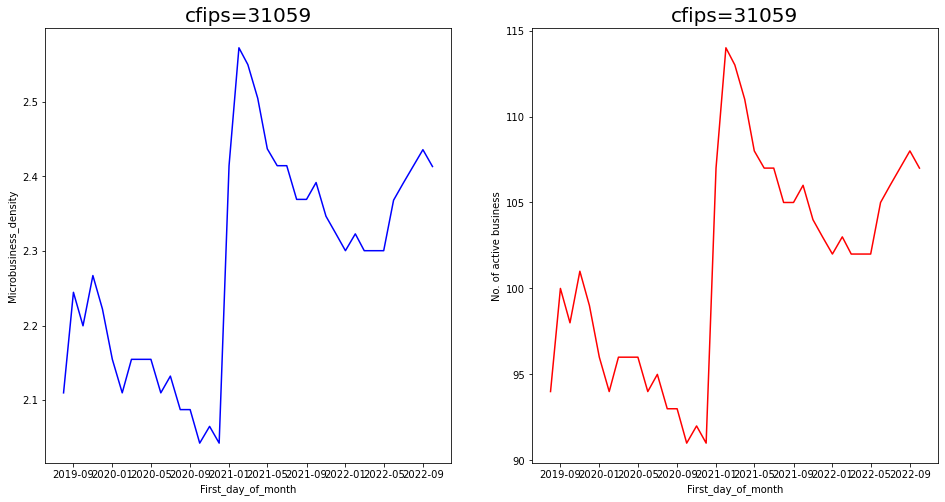

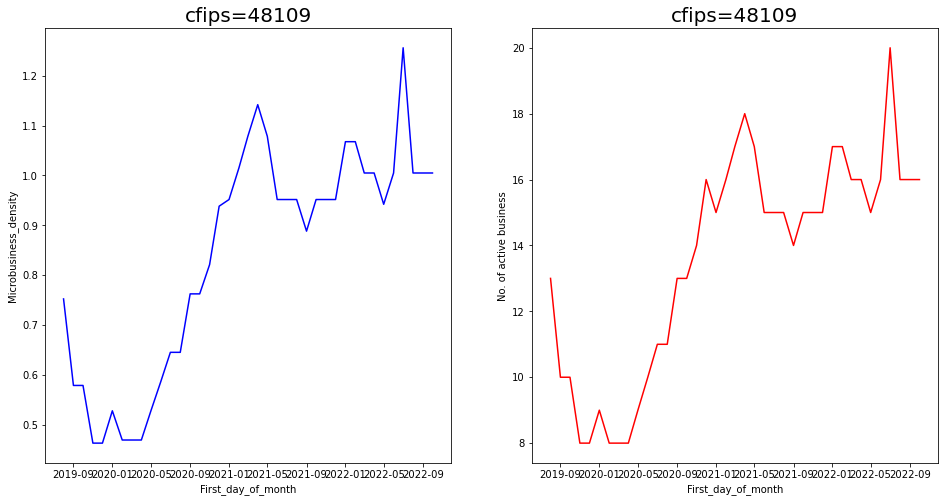

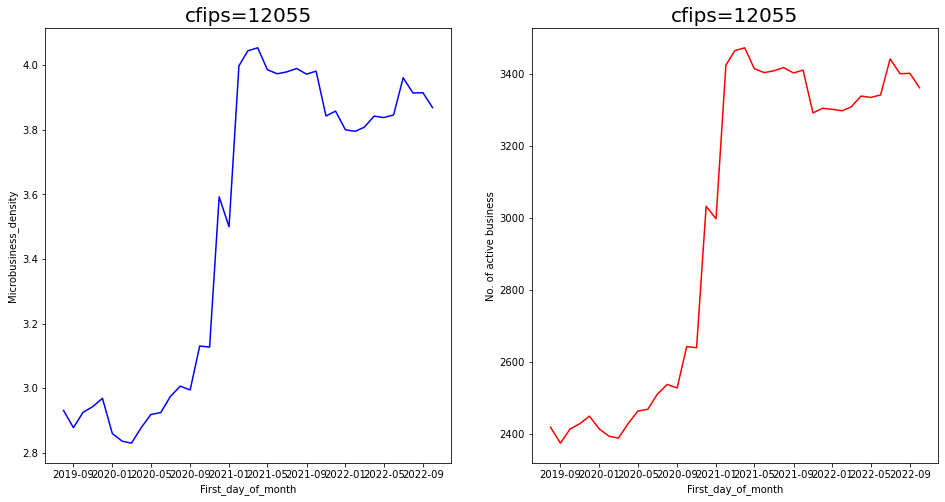

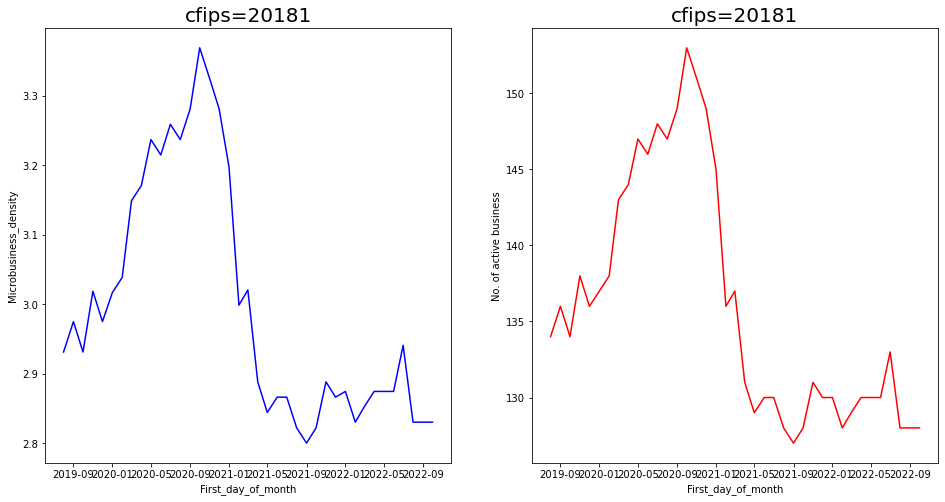

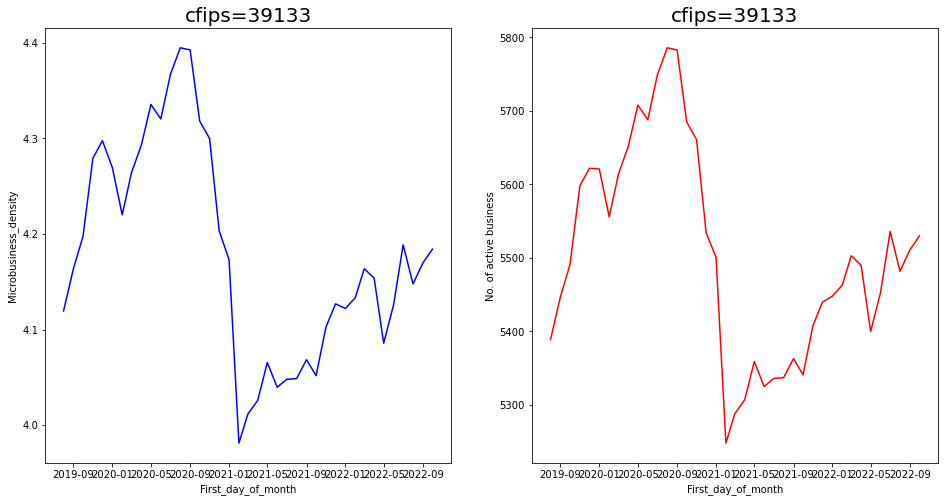

In [ ]:
for i in random.choices(unique_cfips,k=5):
    df=train[train.cfips==i]
    fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(16,8))
    ax[0].plot(df.first_day_of_month,df.microbusiness_density,'b-')
    ax[0].set_xlabel('First_day_of_month')
    ax[0].set_ylabel('Microbusiness_density')
    ax[0].set_title(f'cfips={i}',fontsize=20)
    ax[1].plot(df.first_day_of_month,df.active,'r-')
    ax[1].set_xlabel('First_day_of_month')
    ax[1].set_ylabel('No. of active business')
    ax[1].set_title(f'cfips={i}',fontsize=20)


# The Theta model
The Theta model of Assimakopoulos & Nikolopoulos (2000) is a simple method for forecasting the involves fitting two -lines, forecasting the lines using a Simple Exponential Smoother, and then combining the forecasts from the two lines to produce the final forecast. The model is implemented in steps:

- Test for seasonality

- Deseasonalize if seasonality detected

- Estimate  by fitting a SES model to the data and b0 by OLS.

- Forecast the series

- Reseasonalize if the data was deseasonalized.


![image.png](attachment:image.png)
This module is based on:

Assimakopoulos, V., & Nikolopoulos, K. (2000). The theta model: a decomposition approach to forecasting. International journal of forecasting, 16(4), 521-530.

Hyndman, R. J., & Billah, B. (2003). Unmasking the Theta method. International Journal of Forecasting, 19(2), 287-290.

Fioruci, J. A., Pellegrini, T. R., Louzada, F., & Petropoulos, F. (2015). The optimized theta method. arXiv preprint arXiv:1503.03529.

In [ ]:
unique_cfips[:20]

array([1001, 1003, 1005, 1007, 1009, 1011, 1013, 1015, 1017, 1019, 1021,
       1023, 1025, 1027, 1029, 1031, 1033, 1035, 1037, 1039], dtype=int64)

In [ ]:
df=train[train.cfips==1029]

In [ ]:
tm=ThetaModel(df.microbusiness_density,method='additive',period=3)
res=tm.fit()#use_mle=True
fcast=pd.DataFrame(res.forecast(8,theta=np.inf))
print(res.summary())

                                ThetaModel Results                               
Dep. Variable:     microbusiness_density   No. Observations:                   39
Method:                          OLS/SES   Deseasonalized:                   True
Date:                   Tue, 10 Jan 2023   Deseas. Method:               Additive
Time:                           01:36:03   Period:                              3
Sample:                       08-01-2019                                         
                            - 10-01-2022                                         
    Parameter Estimates    
            Parameters     
---------------------------
b0    0.0034460430026990486
alpha    0.6606691405226373
---------------------------


In [ ]:
#pip install Prophet

In [ ]:
date_range=pd.date_range(start='11-01-22',end='06-01-23',freq='MS')

In [ ]:
fcast['first_day_of_month']=date_range
fcast=fcast.set_index('first_day_of_month')
fcast.head()

,forecast
first_day_of_month,
2022-11-01,1.357953
2022-12-01,1.366686
2023-01-01,1.364642
2023-02-01,1.368291
2023-03-01,1.377024


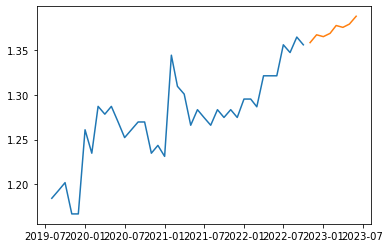

In [ ]:
plt.plot(df.microbusiness_density)
plt.plot(fcast)

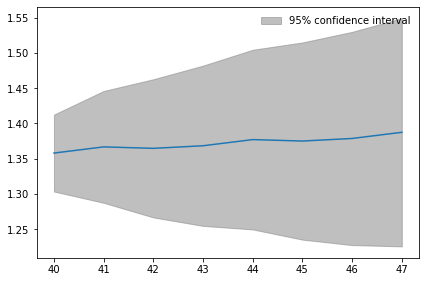

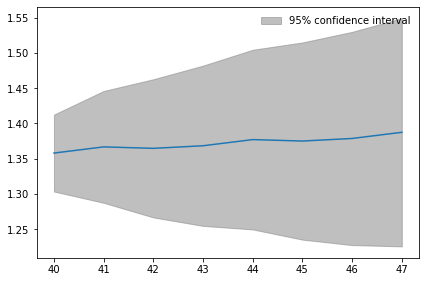

In [ ]:
res.plot_predict(8,theta=np.inf)

In [ ]:
res.forecast_components(8)

,trend,ses,seasonal
40,0.005216,1.354432,-0.001695
41,0.008662,1.354432,0.003593
42,0.012108,1.354432,-0.001898
43,0.015554,1.354432,-0.001695
44,0.019000,1.354432,0.003593
45,0.022446,1.354432,-0.001898
46,0.025892,1.354432,-0.001695
47,0.029338,1.354432,0.003593


In [ ]:
train=train.set_index('first_day_of_month')
train.head()

,row_id,cfips,county,state,microbusiness_density,active
first_day_of_month,,,,,,
2019-08-01,1001_2019-08-01,1001,Autauga County,Alabama,3.007682,1249
2019-09-01,1001_2019-09-01,1001,Autauga County,Alabama,2.884870,1198
2019-10-01,1001_2019-10-01,1001,Autauga County,Alabama,3.055843,1269
2019-11-01,1001_2019-11-01,1001,Autauga County,Alabama,2.993233,1243
2019-12-01,1001_2019-12-01,1001,Autauga County,Alabama,2.993233,1243


In [ ]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive')
    res=tm.fit(use_mle=True)
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=np.inf)
    y_forecast.append(forecast_)

In [ ]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.476801
0    3.489155
0    3.501508
0    3.513862
0    3.526215
dtype: object

In [ ]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.476801
1,1001_2022-12-01,1001,2022-12-01,3.489155
2,1001_2023-01-01,1001,2023-01-01,3.501508
3,1001_2023-02-01,1001,2023-02-01,3.513862
4,1001_2023-03-01,1001,2023-03-01,3.526215


In [ ]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_1.csv',index=False) 
## SMAPE1.771. A dramatic improvements from previous models.

In [ ]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive')
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=np.inf)
    y_forecast.append(forecast_)

In [ ]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.476518
0    3.489722
0    3.502926
0     3.51613
0    3.529334
dtype: object

In [ ]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.476518
1,1001_2022-12-01,1001,2022-12-01,3.489722
2,1001_2023-01-01,1001,2023-01-01,3.502926
3,1001_2023-02-01,1001,2023-02-01,3.51613
4,1001_2023-03-01,1001,2023-03-01,3.529334


In [ ]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_2.csv',index=False) 
## SMAPE1.5784. A dramatic improvements from previous models.

#### theta=3

In [ ]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive')
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=3)
    y_forecast.append(forecast_)

In [ ]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.471807
0    3.480609
0    3.489412
0    3.498215
0    3.507018
dtype: object

In [ ]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.471807
1,1001_2022-12-01,1001,2022-12-01,3.480609
2,1001_2023-01-01,1001,2023-01-01,3.489412
3,1001_2023-02-01,1001,2023-02-01,3.498215
4,1001_2023-03-01,1001,2023-03-01,3.507018


In [ ]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_3.csv',index=False) 
## SMAPE 1.421. A dramatic improvements from previous models.

#### theta=2

In [ ]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive')
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=2)
    y_forecast.append(forecast_)

In [ ]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.469451
0    3.476053
0    3.482655
0    3.489257
0     3.49586
dtype: object

In [ ]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.469451
1,1001_2022-12-01,1001,2022-12-01,3.476053
2,1001_2023-01-01,1001,2023-01-01,3.482655
3,1001_2023-02-01,1001,2023-02-01,3.489257
4,1001_2023-03-01,1001,2023-03-01,3.49586


In [ ]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_4.csv',index=False) 
## SMAPE 1.3608. A dramatic improvements from previous models.

#### theta=1.5

In [ ]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive')
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=1.5)
    y_forecast.append(forecast_)

In [ ]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.467096
0    3.471497
0    3.475899
0      3.4803
0    3.484701
dtype: object

In [ ]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.467096
1,1001_2022-12-01,1001,2022-12-01,3.471497
2,1001_2023-01-01,1001,2023-01-01,3.475899
3,1001_2023-02-01,1001,2023-02-01,3.4803
4,1001_2023-03-01,1001,2023-03-01,3.484701


In [ ]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_5.csv',index=False) 
## SMAPE 1.3085. A dramatic improvements from previous models.

### Hyperparameter tuning-Theta model

In [ ]:
periods=[12]
use_mle=[False,True]
thetas=[1,np.inf]
cfips_list=[]
best_para=[]
for cfips in unique_cfips:
    cfips_list.append(cfips)
    list_=[]
    df=train[train.cfips==cfips].microbusiness_density
    df_train=df[:31]
    df_val=pd.Series(df[31:])
    for period in periods:
        tm=ThetaModel(df_train,method='additive',period=period)
        for i in use_mle:
            res=tm.fit(use_mle=i)#use_mle=True
            for theta in thetas:
                forecast_=pd.Series(res.forecast(8,theta=theta))
                list_.append(((f'period:{period}, use_mle:{i}, theta:{theta}'),MAPE(df_val,forecast_)))
    best_param=sorted(list(enumerate(list_)),key= lambda x:x[1][1])[0][1][0]
    best_para.append(best_param)

In [ ]:
best_param=pd.Series(best_para)
cfips_series=pd.Series(cfips_list)

In [ ]:
df_temp=pd.concat([best_param,cfips_series],axis=1,ignore_index=True)
df_grouped=df_temp.groupby([0])[1].agg('unique').reset_index()
df_grouped['length']=df_grouped[1].apply(lambda x:len(x))
df_grouped

,0,1,length
0,"period:12, use_mle:False, theta:1","[1007, 1011, 1017, 1025, 1033, 1035, 1039, 104...",1269
1,"period:12, use_mle:False, theta:inf","[1001, 1003, 1005, 1009, 1021, 1037, 1055, 105...",659
2,"period:12, use_mle:True, theta:1","[1013, 1019, 1027, 1051, 1071, 1079, 1093, 112...",408
3,"period:12, use_mle:True, theta:inf","[1015, 1023, 1029, 1031, 1041, 1043, 1045, 104...",799


In [ ]:
temp=df_grouped[0].str.split(',',expand=True).rename(columns={0:'period',1:'use_mle',2:'theta'})

In [ ]:
df_merged=pd.concat([df_grouped,
           temp['period'].str.split(':',expand=True),
           temp['use_mle'].str.split(':',expand=True),
           temp['theta'].str.split(':',expand=True)],axis=1,ignore_index=True)
df_merged.head()

,0,1,2,3,4,5,6,7,8
0,"period:12, use_mle:False, theta:1","[1007, 1011, 1017, 1025, 1033, 1035, 1039, 104...",1269,period,12,use_mle,False,theta,1
1,"period:12, use_mle:False, theta:inf","[1001, 1003, 1005, 1009, 1021, 1037, 1055, 105...",659,period,12,use_mle,False,theta,inf
2,"period:12, use_mle:True, theta:1","[1013, 1019, 1027, 1051, 1071, 1079, 1093, 112...",408,period,12,use_mle,True,theta,1
3,"period:12, use_mle:True, theta:inf","[1015, 1023, 1029, 1031, 1041, 1043, 1045, 104...",799,period,12,use_mle,True,theta,inf


In [ ]:
df_merged=df_merged.drop([0,2,3,5,7],axis=1)
df_merged.columns=['cfips_list','period','use_mle','theta']
df_merged

,cfips_list,period,use_mle,theta
0,"[1007, 1011, 1017, 1025, 1033, 1035, 1039, 104...",12,False,1
1,"[1001, 1003, 1005, 1009, 1021, 1037, 1055, 105...",12,False,inf
2,"[1013, 1019, 1027, 1051, 1071, 1079, 1093, 112...",12,True,1
3,"[1015, 1023, 1029, 1031, 1041, 1043, 1045, 104...",12,True,inf


In [ ]:
df_merged.theta[df_merged.theta=='inf']=np.inf
df_merged.head()

,cfips_list,period,use_mle,theta
0,"[1007, 1011, 1017, 1025, 1033, 1035, 1039, 104...",12,False,1
1,"[1001, 1003, 1005, 1009, 1021, 1037, 1055, 105...",12,False,inf
2,"[1013, 1019, 1027, 1051, 1071, 1079, 1093, 112...",12,True,1
3,"[1015, 1023, 1029, 1031, 1041, 1043, 1045, 104...",12,True,inf


In [ ]:
df_merged['period']=df_merged['period'].astype('int64')
df_merged['use_mle']=df_merged['use_mle'].astype('bool')
df_merged['theta']=df_merged['theta'].astype('float')

In [ ]:
y_forecast=[]
cfips_list=[]
for index,row in df_merged.iterrows():
    for i in row['cfips_list']:
        cfips_list.append([i]*8)
        df=train[train.cfips==i]
        tm=ThetaModel(df.microbusiness_density,method='additive',period=row['period'])
        res=tm.fit(use_mle=row['use_mle'])
    #perform rolling prediction and multistep forecast
        if row['theta']=='inf':
            forecast_=res.forecast(8,theta=np.row['theta'])
        else:
            forecast_=res.forecast(8,theta=row['theta'])
        y_forecast.append(forecast_)

In [ ]:
cfips_list=pd.Series(cfips_list).explode()
y_forecast=pd.Series(y_forecast).explode()
y_predict=pd.concat([cfips_list,y_forecast],axis=1,ignore_index=True)
y_predict.columns=['cfips','microbusiness_density']
y_predict.head()

,cfips,microbusiness_density
0,1007,1.292623
0,1007,1.296219
0,1007,1.286305
0,1007,1.301378
0,1007,1.289573


In [ ]:
y_predict=y_predict.sort_values('cfips').reset_index()
y_predict=y_predict.drop('index',axis=1)
y_predict.head()

,cfips,microbusiness_density
0,1001,3.476801
1,1001,3.489155
2,1001,3.501508
3,1001,3.513862
4,1001,3.526215


In [ ]:
df=pd.concat([test,y_predict],axis=1,ignore_index=True)
df.head(20)

,0,1,2,3,4
0,1001_2022-11-01,1001,2022-11-01,1001,3.476801
1,1001_2022-12-01,1001,2022-12-01,1001,3.489155
2,1001_2023-01-01,1001,2023-01-01,1001,3.501508
3,1001_2023-02-01,1001,2023-02-01,1001,3.513862
4,1001_2023-03-01,1001,2023-03-01,1001,3.526215
5,1001_2023-04-01,1001,2023-04-01,1001,3.538568
6,1001_2023-05-01,1001,2023-05-01,1001,3.550922
7,1001_2023-06-01,1001,2023-06-01,1001,3.563275
8,1003_2022-11-01,1003,2022-11-01,1003,8.448263
9,1003_2022-12-01,1003,2022-12-01,1003,8.595691


In [ ]:
test.columns

Index(['row_id', 'cfips', 'first_day_of_month'], dtype='object')

In [ ]:
df.columns=['row_id', 'cfips', 'first_day_of_month','cfips_2','microbusiness_density']
df.head()

,row_id,cfips,first_day_of_month,cfips_2,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,1001,3.476801
1,1001_2022-12-01,1001,2022-12-01,1001,3.489155
2,1001_2023-01-01,1001,2023-01-01,1001,3.501508
3,1001_2023-02-01,1001,2023-02-01,1001,3.513862
4,1001_2023-03-01,1001,2023-03-01,1001,3.526215


In [ ]:
df.shape

(25080, 5)

In [ ]:
sub=df[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_hyper7.csv',index=False) 

Using the hyperparameter tuning didn't result in any improvement in the result. It rather increases the MAPE.
In this steps, I explored

### period=12,theta=1,use_mle=false

In [ ]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive',period=12)
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=1)
    y_forecast.append(forecast_)

In [ ]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.462385
0    3.462385
0    3.462385
0    3.462385
0    3.462385
dtype: object

In [ ]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.462385
1,1001_2022-12-01,1001,2022-12-01,3.462385
2,1001_2023-01-01,1001,2023-01-01,3.462385
3,1001_2023-02-01,1001,2023-02-01,3.462385
4,1001_2023-03-01,1001,2023-03-01,3.462385


In [ ]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_6.csv',index=False) 
## SMAPE 1.171. This is the best score so far.

### period=3, theta=1,use_mle=false

In [ ]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive',period=3)
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=1)
    y_forecast.append(forecast_)

In [ ]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.440106
0    3.463908
0    3.444323
0    3.440106
0    3.463908
dtype: object

In [ ]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.440106
1,1001_2022-12-01,1001,2022-12-01,3.463908
2,1001_2023-01-01,1001,2023-01-01,3.444323
3,1001_2023-02-01,1001,2023-02-01,3.440106
4,1001_2023-03-01,1001,2023-03-01,3.463908


In [ ]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_7.csv',index=False) 
## SMAPE 1.46. A dramatic improvements from previous models.

### period=3, theta=inf,

In [ ]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive',period=3)
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=np.inf)
    y_forecast.append(forecast_)

In [ ]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.453612
0    3.490567
0    3.484134
0     3.49307
0    3.530025
dtype: object

In [ ]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.453612
1,1001_2022-12-01,1001,2022-12-01,3.490567
2,1001_2023-01-01,1001,2023-01-01,3.484134
3,1001_2023-02-01,1001,2023-02-01,3.49307
4,1001_2023-03-01,1001,2023-03-01,3.530025


In [ ]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_8.csv',index=False) 
## SMAPE 1.71. Increased!

###  period=12, theta=1,use_mle=True

In [ ]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive',period=12)
    res=tm.fit(use_mle=True)
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=1)
    y_forecast.append(forecast_)

In [ ]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.462683
0    3.462683
0    3.462683
0    3.462683
0    3.462683
dtype: object

In [ ]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.462683
1,1001_2022-12-01,1001,2022-12-01,3.462683
2,1001_2023-01-01,1001,2023-01-01,3.462683
3,1001_2023-02-01,1001,2023-02-01,3.462683
4,1001_2023-03-01,1001,2023-03-01,3.462683


In [ ]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_9.csv',index=False) 
## SMAPE 1.3835.

### period=12,theta=inf,use_mle-false

In [ ]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive',period=12)
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=np.inf)
    y_forecast.append(forecast_)

In [ ]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.476518
0    3.489722
0    3.502926
0     3.51613
0    3.529334
dtype: object

In [ ]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.476518
1,1001_2022-12-01,1001,2022-12-01,3.489722
2,1001_2023-01-01,1001,2023-01-01,3.502926
3,1001_2023-02-01,1001,2023-02-01,3.51613
4,1001_2023-03-01,1001,2023-03-01,3.529334


In [ ]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_10.csv',index=False) 
## SMAPE 1.58. A dramatic improvements from previous models.